# Importing from modules

In [2]:
# imports
import pickle
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
import lime
import lime.lime_tabular
import shap
from sklearn.inspection import permutation_importance
from typing import Tuple, Union, Optional, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from importlib import reload
import constants
import data_utils
import models
import training_and_selection

In [3]:
reload(data_utils)
from data_utils import get_dataset

X, y = get_dataset()
BASELINE = np.sum(y == 1) / np.sum(y == 0)

/home/krzaq/xai/XAI-team-project/data_utils.py:31: DtypeWarning: Columns (4,11,12,16,17,18,19,20,40,41,42,43,44,45,52,53,54,55,56,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,108,110) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("SpeedDating.csv", index_col=0)


In [5]:
reload(constants)
reload(models)
from constants import (
    SEED,
    NUM_SPLITS,
    INITIAL_CUTOFF,
    TOP,
    TARGET,
    MODEL_ACCURACIES_PATH,
    FILTERED_MODEL_ACCURACIES_PATH,
    TIME_LIMIT,
    TIME_LIMIT_CROSS_VALIDATION,
)
from models import MODELS, HYPERPARAMETERS

In [6]:
reload(constants)
reload(training_and_selection)
from training_and_selection import get_rashomon_sets

rashomon_sets_params = get_rashomon_sets(
    models=MODELS,
    hyperparameters=HYPERPARAMETERS,
    X=X,
    y=y,
    initial_cutoff=INITIAL_CUTOFF,
    top=TOP,
)
pickle.dump(rashomon_sets_params, open('rashomon_sets_params.pickle', 'wb'))

SVMClassifier


2it [00:07,  3.77s/it]


TabRClassifier


0it [00:00, ?it/s]/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)
1it [00:09,  9.69s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

2it [00:19,  9.58s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

3it [00:33, 11.53s/it]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

4it [00:48, 12.11s/it]


XGBClassifier


4it [00:00,  4.27it/s]
  0%|          | 0/3 [00:00<?, ?it/s]/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:43<01:27, 43.85s/it]/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [01:52<00:58, 58.57s/it]/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/268 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


# XAI things

In [ ]:
# rashomon_sets_params = pickle.load(open('rashomon_sets_params.pickle', 'rb'))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=(SEED+1))
rashomon_sets = {}
rashomon_sets_acc_lower_bounds = {}
accuracies = {}
for model_class in MODELS:
    rashomon_sets[model_class.__name__] = []
    accuracies[model_class.__name__] = []
    for kwargs in rashomon_sets_params[model_class.__name__]:
        if model_class.__name__ == 'SVMClassifier':
            model = model_class(probability=True, **kwargs)
        else:
            model = model_class(**kwargs)
        model.fit(X_train, y_train)
        acc = np.mean(model.predict(X_test) == np.array(y_test))
        accuracies[model_class.__name__].append(acc)
        rashomon_sets[model_class.__name__].append(model)
    rashomon_sets_acc_lower_bounds[model_class.__name__] = min(accuracies[model_class.__name__])

/home/krzaq/xai/XAI-team-project/pytorch_tabr/base_model.py:258: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/home/krzaq/.local/share/mamba/envs/tabr/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


 epochs:   0%|          | 0/1 [00:00<?, ?it/s]

 batches:   0%|          | 0/301 [00:00<?, ?it/s]

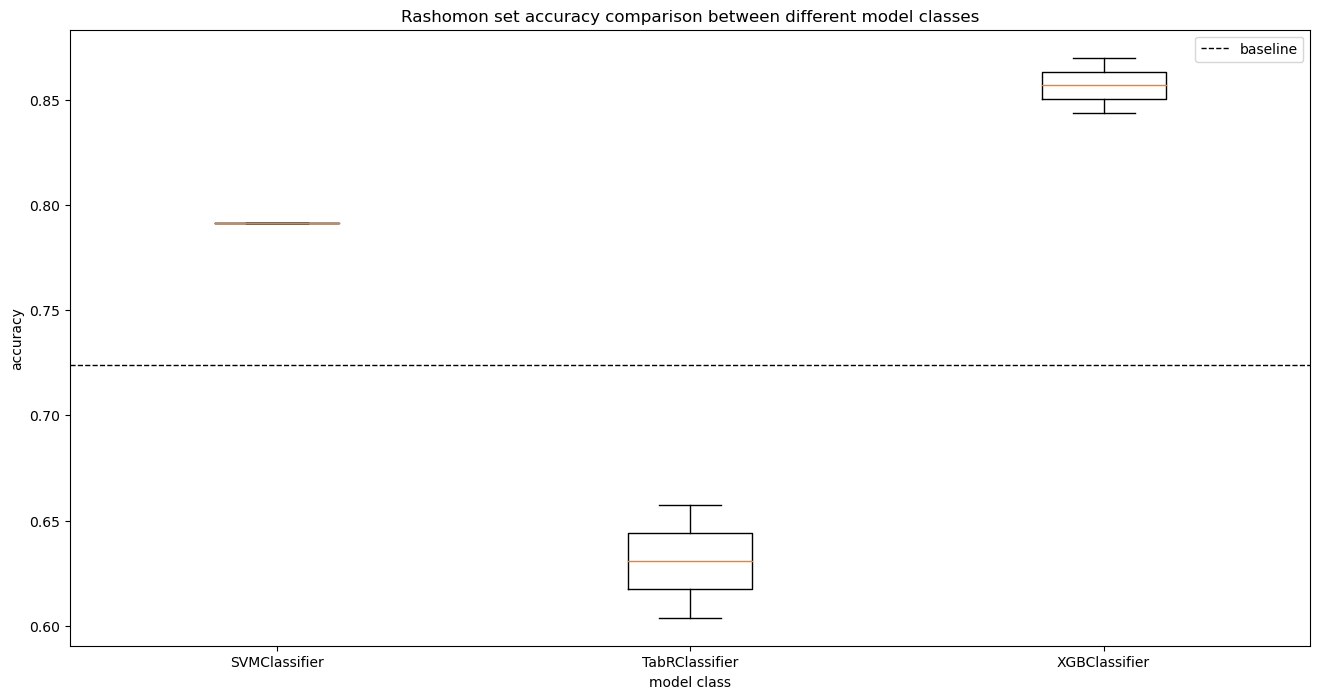

In [8]:
# Compare accuracies for different Rashomon sets
plt.figure(figsize=(16, 8))
plt.title("Rashomon set accuracy comparison between different model classes")
plt.axhline(BASELINE, color='black', linestyle='--', linewidth=1, label='baseline')
plt.xlabel('model class')
plt.ylabel('accuracy')
plt.boxplot([accuracies[model_class.__name__] for model_class in MODELS])
plt.xticks(np.arange(1, 1+len(MODELS)), [model_class.__name__ for model_class in MODELS])
plt.legend()

In [9]:
INDICES = [42, 123, 314]
RANDOM_SAMPLES = [X_test.iloc[i, :] for i in INDICES]

In [ ]:
# Permutation feature importance

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            importances = permutation_importance(model, X_test, y_test,
                           n_repeats=1,
                           random_state=SEED,
                            scoring="accuracy")
            importances = pd.Series(importances['importances'][:, 0], index=list(X.columns))
            fig, ax = plt.subplots()
            importances.plot.bar(ax=ax)
            ax.set_title("Permutation feature importances")
            ax.set_ylabel("importance")
            fig.tight_layout()

In [11]:
for model_class in MODELS:
    print(len(rashomon_sets[model_class.__name__]))

1
2
2


In [ ]:
# LIME
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical_features = [0, 3, 4, -1]
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), categorical_features=categorical_features, feature_names=list(X.columns), class_names=['negative', 'positive'])
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            explaination = lime_explainer.explain_instance(X_test.iloc[SEED, :], model.predict_proba, num_features=5)
            fig = explaination.as_pyplot_figure()
            plt.plot()


In [13]:
# Shap
i = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in MODELS:
        for model in rashomon_sets[model_class.__name__]:
            i += 1
            if i <= 4:
                continue
            # if hasattr(model, "feature_names_in_"):
            # model.fit(X_train.values, y_train.values)
            print(type(X_train.iloc[:100, :]))
            shap_explainer = shap.KernelExplainer(model.predict, X_train.iloc[:100, :].to_numpy(), feature_names=list(X.columns))
            explaination = shap_explainer(X_test.iloc[[SEED], :])
            shap_values = explaination.values
            shap.plots.beeswarm(explaination)
            plt.plot()


<class 'pandas.core.frame.DataFrame'>


AttributeError: can't set attribute